In [1]:
import pandas as pd
import os
import datetime as dt
from datetime import date as date_func
import random

In [2]:
import pickle
import glob
import re
import os
import copy
import subprocess
import timeit
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from functools import reduce

import vcf
import pysam
import numpy as np
import pandas as pd
import dask.dataframe as dd
from Bio import SeqIO
from Bio.SeqUtils import seq1

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [4]:
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
def get_plot_data(mut_label, clinical_cryptic_df):
    clinical_mutation_df = clinical_cryptic_df[clinical_cryptic_df['Nt Mutations'] == mut_label]
    #clinical_mutation_df = clinical_cryptic_df[(clinical_cryptic_df['Nt Mutations'] == mut_label) & (clinical_cryptic_df['Combined Freq'] >= 0.02)]
    ww_df = wastewater_df[wastewater_df['Nt Mutations'] == mut_label]
    x_ticklabels = []
    p_rates = []
    ww_counts = []
    has_data = []
    sample_counts = []
    freqs = []

    for i in range(0, 8):
        start = sampling_date_start + i*week_offset
        end = sampling_date_start + (i+1)*week_offset

        weekly_clinical_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
        ww_count = ww_df[(ww_df['Date'] >= start) & (ww_df['Date'] < end)].shape[0]

        weekly_sample_count = weekly_clinical_df.shape[0]
        sample_counts.append(weekly_sample_count)
        #count_present = weekly_clinical_df[weekly_clinical_df['Support DP'] >= 10].shape[0]
        supported_sample_df = weekly_clinical_df[(weekly_clinical_df['Support DP'] >= 10) & (weekly_clinical_df['Combined Freq'] >= freq_cutoff)]
        supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]
        #supported_sample_df = weekly_clinical_df[(weekly_clinical_df['Overlapping Support DP'] >= 10) & (weekly_clinical_df['Combined Freq'] >= freq_cutoff)]
        count_present = supported_sample_df.shape[0]
        count_no_data = weekly_clinical_df[weekly_clinical_df['Total DP'] == 0].shape[0]
        
        #freq = weekly_clinical_df[weekly_clinical_df['Support DP'] >= 10]['Combined Freq'].mean()
        freq = supported_sample_df['Combined Freq'].values
        freqs.append(freq)

        count_exclude_no_data = weekly_sample_count - count_no_data

        if count_exclude_no_data > 0:
            p_rate = count_present/count_exclude_no_data
            has_data.append(2)
        else:
            p_rate = np.nan
            has_data.append(0)

        #time_label = start.strftime('%m/%d/%y') + ' - ' + (end-timedelta(days=1)).strftime('%m/%d/%y')
        time_label = start.strftime('%m-%d-%y')
        x_ticklabels.append(time_label)
        p_rates.append(p_rate)
        if ww_count > 0:
            ww_counts.append(2)
        else:
            ww_counts.append(np.nan)
            
    return x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs

# Selected Mutations

In [7]:
selected_cryptic_mutations = ['T28823G;G28881A;G28882A;G28883C',
                              'C6402T;G6456A',
                              'A26530G;C26533T;C26542A;T26545G',
                              'A26530G;T26545G',
                              'A27259C;C27335T;A27344T;A27345T',
                              'T29029C;A29039T',
                              'A26530G;C26577G;C26625A',
                              'C10449A;T10459C',
                              'T15682A;T15685A',
                              'A24966T;C25000T',
                              'A27344T;A27345T;A27354G',
                              'A29039T;G29049A']

In [8]:
sampling_date_start =  pd.to_datetime('12/06/2021')

In [9]:
week_offset = timedelta(days=7)

In [10]:
freq_cutoff = 0.02

In [11]:
wastewater_df = pd.read_csv('/home/Users/yl181/wastewater/quarc_figures/merged_df.csv', index_col=0)
wastewater_df['Date'] = wastewater_df['Date'].apply(str)
wastewater_df['Date'] = pd.to_datetime(wastewater_df['Date'], format='%Y-%m-%d')
len(wastewater_df['Nt Mutations'].unique())

6818

# Houston

## Metadata

In [12]:
houston_df = pd.read_csv('filtered_houston_df.csv', index_col=0)
houston_df['Collection_Date'] =  pd.to_datetime(houston_df['Collection_Date'], format='%Y-%m-%d')
houston_df['Date'] = houston_df['Collection_Date']

In [13]:
houston_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex,taxon,lineage,SB_p_value,SB,Date
0,SRR17385361,0,A29039T;G29049A;A29301G,0,113,0,0,0,0,0,...,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000,2021-12-14
1,SRR17385361,0,G29050A;A29301G,0,164,0,0,0,0,0,...,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000,2021-12-14
2,SRR17385361,0,A26530G;C26577G;G26634A,0,1,0,0,0,0,0,...,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000,2021-12-14
3,SRR17385361,0,T13078C;T13195C,0,231,0,0,0,0,0,...,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000,2021-12-14
4,SRR17385361,0,A26530G;C26533T;C26542A;T26545G,0,1508,242,1195,0,0,0,...,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000,2021-12-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101195,SRR18133357,5059,T29029C;A29039T,6,1517,1080,1105,3,6,3,...,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,1.000000,0.000000,2021-12-22
101196,SRR18133357,5059,A24966T;C25000T,10,1818,1034,851,10,1,1,...,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,0.028278,1.448688,2021-12-22
101197,SRR18133357,5059,A27344T;A27345T;A27354G,13,1343,877,838,11,4,2,...,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,1.000000,0.000000,2021-12-22
101198,SRR18133357,5059,T23599G;C23604A;G23642T,0,670,258,186,0,0,0,...,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,1.000000,0.000000,2021-12-22


## Lineage

In [14]:
def filtering(clinical_mutation_df, mut_label):
    clinical_mutation_df = clinical_mutation_df[clinical_mutation_df['Nt Mutations'] == mut_label].copy()
    start = sampling_date_start + 0*week_offset
    end = sampling_date_start + (7+1)*week_offset
    clinical_mutation_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
    supported_sample_df = clinical_mutation_df[(clinical_mutation_df['Support DP'] >= 10) & (clinical_mutation_df['Combined Freq'] >= freq_cutoff)]
    supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]
    
    return supported_sample_df

In [15]:
def get_lineage_values(df, mut_label, state):
    lineage_mutation_df = pd.pivot_table(filtering(df, mut_label), values='SRA Accession ID', index='lineage', columns='Nt Mutations', 
                   aggfunc='count').fillna(0)
    lineage_mutation_df.index.unique()

    group_labels = []
    for idx, _ in lineage_mutation_df.iterrows():
        if idx.startswith('AY.'):
            group_labels.append('Delta')
        elif idx == 'BA.1.15' or idx.startswith('BA.1.15.'):
            group_labels.append('BA.1.15')
        elif idx == 'BA.1.17' or idx.startswith('BA.1.17.'):
            group_labels.append('BA.1.17')
        elif idx == 'BA.1.18' or idx.startswith('BA.1.18.'):
            group_labels.append('BA.1.18')
        elif idx == 'BA.1.20' or idx.startswith('BA.1.20.'):
            group_labels.append('BA.1.20')
        elif idx == 'BA.1.1' or idx.startswith('BA.1.1.'):
            group_labels.append('BA.1.1')
        else:
            group_labels.append('Omicron')
    lineage_mutation_df['Label'] = group_labels
    
    lineage_mutation_df = lineage_mutation_df.groupby(lineage_mutation_df['Label']).sum()
    
    # if lineage_mutation_df[mut_label].values.sum() != 0:
    #     lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
    # else:
    #     lineage_values = lineage_mutation_df[mut_label].values
    # lineage_labels = lineage_mutation_df[mut_label].index
    # return lineage_values, lineage_labels
    
    lineage_mutation_df = lineage_mutation_df.rename({mut_label: state}, axis=1).transpose()
    return lineage_mutation_df
    
    

In [16]:
def get_lineage_plot_data(mut_label):
    states = ['Houston', 'Maryland', 'Massachusetts', 'California', 'Colorado', 'Utah'][::-1]
    lineage_array = []
    for state in states:
        if state == 'Houston':
            lineage_mutation_df = get_lineage_values(houston_df, mut_label, state).copy()
        else:
            temp_df = us_df[us_df['Region'] == state]
            lineage_mutation_df = get_lineage_values(temp_df, mut_label, state).copy()
        
        if not lineage_mutation_df.empty:
            lineage_array.append(lineage_mutation_df)
    
    return lineage_array

In [17]:
from operator import add

# Multi-cryptic Plot

In [18]:
def filtering_full(clinical_mutation_df):
    clinical_mutation_df = clinical_mutation_df.copy()
    start = sampling_date_start + 0*week_offset
    end = sampling_date_start + (7+1)*week_offset
    clinical_mutation_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
    supported_sample_df = clinical_mutation_df[(clinical_mutation_df['Support DP'] >= 10) & (clinical_mutation_df['Combined Freq'] >= freq_cutoff)]
    supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]
    
    return supported_sample_df

In [19]:
lineage_mutation_df = pd.pivot_table(filtering_full(houston_df), values='SRA Accession ID', index='lineage', columns='Nt Mutations', 
               aggfunc='count').fillna(0)
lineage_mutation_df.index.unique()

group_labels = []
for idx, _ in lineage_mutation_df.iterrows():
    if idx.startswith('AY.'):
        group_labels.append('Delta')
    elif idx == 'BA.1.15' or idx.startswith('BA.1.15.'):
        group_labels.append('BA.1.15')
    elif idx == 'BA.1.17' or idx.startswith('BA.1.17.'):
        group_labels.append('BA.1.17')
    elif idx == 'BA.1.18' or idx.startswith('BA.1.18.'):
        group_labels.append('BA.1.18')
    elif idx == 'BA.1.20' or idx.startswith('BA.1.20.'):
        group_labels.append('BA.1.20')
    elif idx == 'BA.1.1' or idx.startswith('BA.1.1.'):
        group_labels.append('BA.1.1')
    else:
        group_labels.append('Omicron')
lineage_mutation_df['Label'] = group_labels
lineage_mutation_df = lineage_mutation_df.groupby(lineage_mutation_df['Label']).sum()



Text(0.815, 0.5, 'Mean Allele Frequency')

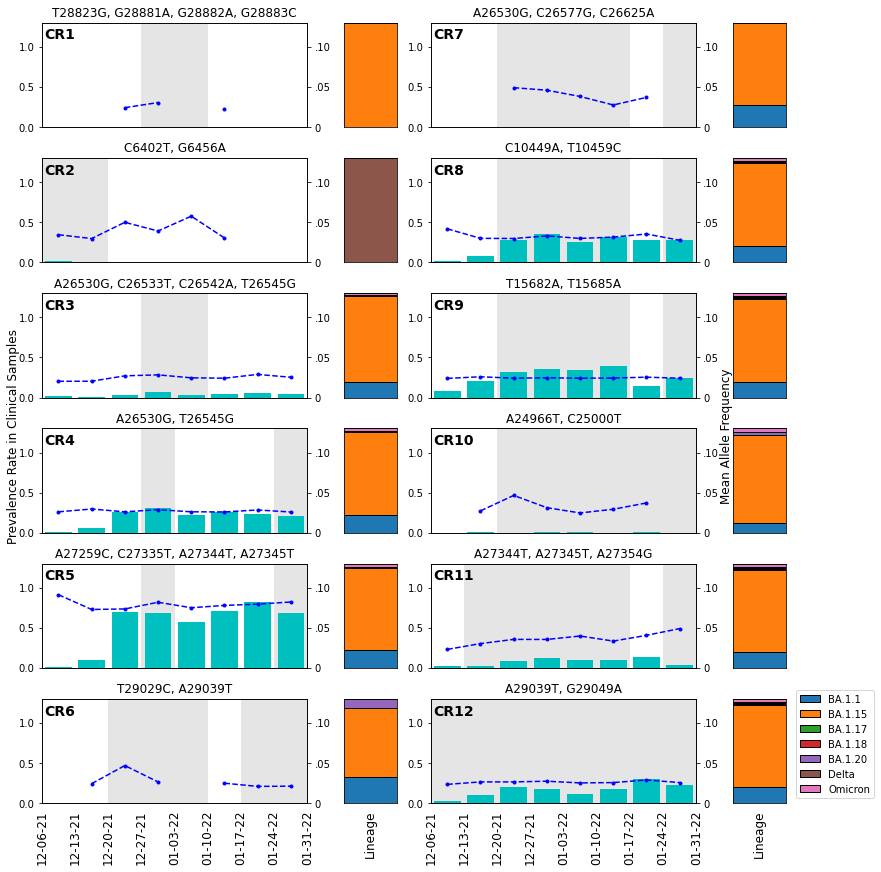

In [49]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 4, figsize=(12, num*2), sharex=False, constrained_layout=True, gridspec_kw={'width_ratios': [5, 1, 5, 1], 'wspace':0.35})

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][2]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label, houston_df)

    ax.bar(x, ww_counts, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)

    ax.text(0.01, 0.95, f'CR{ax_idx+7}', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top')
    ax_twin = ax.twinx()
    ax_twin.plot(x, [a.mean() for a in np.array(freqs)], 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][3]
    bottom = 0
    lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
    lineage_labels = lineage_mutation_df[mut_label].index
    for idx, label in enumerate(lineage_labels):
        p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
        bottom += lineage_values[idx]
    
    ax2.set_ylim(0,1)
    ax2.set_xlim(-0.2,0.2)
    ax2.xaxis.set_ticks_position('none')
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

ax2.legend(loc=4, bbox_to_anchor=(2.75, 0, 0, 0))

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label, houston_df)

    ax.bar(x, ww_counts, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax.text(0.01, 0.95, f'CR{ax_idx+1}', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top')
        
    ax_twin = ax.twinx()
    ax_twin.plot(x, [a.mean() for a in np.array(freqs)], 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][1]
    bottom = 0
    lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
    lineage_labels = lineage_mutation_df[mut_label].index
    for idx, label in enumerate(lineage_labels):
        p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
        bottom += lineage_values[idx]
    
    ax2.set_ylim(0,1)
    ax2.set_xlim(-0.2,0.2)
    ax2.xaxis.set_ticks_position('none')
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.01, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
#fig.text(.365, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)
#fig.text(0.445, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(.815, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

#fig.suptitle(f"Houston Clinical Samples (Filter SB/DP=10/AF={freq_cutoff})", fontsize=14)

# US

In [21]:
us_df = pd.read_csv('filtered_us_df.csv', index_col=0)
us_df['Collection_Date'] =  pd.to_datetime(us_df['Collection_Date'], format='%Y-%m-%d')
us_df['Date'] = us_df['Collection_Date']

In [22]:
us_df[(us_df['Region'] == 'Maryland') & (us_df['Nt Mutations'] == mut_label)]

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Region,Country,Pango,CDC,Date,taxon,lineage,SB_p_value,SB,Collection_Date
215,SRR18124929,10,T29029C;A29039T,22,4346,2565,2088,4,22,4,...,Maryland,USA,BA.1.1,Omicron,2022-01-13,SRR18124929,BA.1.1,1.0,0.0,2022-01-13
415,SRR18125553,20,T29029C;A29039T,14,4849,3117,2545,4,14,4,...,Maryland,USA,BA.1.1,Omicron,2022-01-13,SRR18125553,BA.1.1,1.0,0.0,2022-01-13
435,SRR18125588,21,T29029C;A29039T,21,3995,2556,2603,12,18,9,...,Maryland,USA,BA.1.1.17,Omicron,2022-01-13,SRR18125588,BA.1.1.17,1.0,0.0,2022-01-13
615,SRR18131167,30,T29029C;A29039T,48,3985,2619,2521,28,42,23,...,Maryland,USA,BA.1.18,Omicron,2022-01-13,SRR18131167,BA.1.18,1.0,0.0,2022-01-13
875,SRR18125585,43,T29029C;A29039T,24,4061,2546,2706,16,24,16,...,Maryland,USA,BA.1.1,Omicron,2022-01-13,SRR18125585,BA.1.1,1.0,0.0,2022-01-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168355,SRR18124865,8420,T29029C;A29039T,11,4144,3080,2923,8,11,8,...,Maryland,USA,BA.1.1,Omicron,2021-12-27,SRR18124865,BA.1.1,1.0,0.0,2021-12-27
168375,SRR18124875,8421,T29029C;A29039T,35,4308,2543,2436,10,33,8,...,Maryland,USA,BA.1.1,Omicron,2021-12-27,SRR18124875,BA.1.1,1.0,0.0,2021-12-27
170295,SRR18124863,8517,T29029C;A29039T,18,4205,2521,2691,9,18,9,...,Maryland,USA,BA.1,Omicron,2021-12-27,SRR18124863,BA.1,1.0,0.0,2021-12-27
171415,SRR18124872,8573,T29029C;A29039T,22,3926,2511,2544,9,19,6,...,Maryland,USA,BA.1.17,Omicron,2021-12-27,SRR18124872,BA.1.17,1.0,0.0,2021-12-27


In [23]:
def get_heatmap_data(mut_label, clinical_cryptic_df, regions, exclude=False):
    clinical_mutation_df = clinical_cryptic_df[(clinical_cryptic_df['Nt Mutations'] == mut_label)]
    
    if not exclude:
        for region in regions:
            clinical_mutation_df = clinical_mutation_df[clinical_mutation_df['Region'] == region]
    else:
        for region in regions:
            clinical_mutation_df = clinical_mutation_df[clinical_mutation_df['Region'] != region]

    x_ticklabels = []
    p_rates = []
    has_data = []
    sample_counts = []
    freqs = []

    for i in range(0, 8):
        start = sampling_date_start + i*week_offset
        end = sampling_date_start + (i+1)*week_offset

        weekly_clinical_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
        weekly_sample_count = weekly_clinical_df.shape[0]
        sample_counts.append(weekly_sample_count)
        #count_present = weekly_clinical_df[weekly_clinical_df['Support DP'] >= 10].shape[0]
        supported_sample_df = weekly_clinical_df[(weekly_clinical_df['Support DP'] >= 10) & (weekly_clinical_df['Combined Freq'] >= freq_cutoff)]
        supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]
        #supported_sample_df = weekly_clinical_df[(weekly_clinical_df['Overlapping Support DP'] >= 10) & (weekly_clinical_df['Combined Freq'] >= freq_cutoff)]
        count_present = supported_sample_df.shape[0]
        count_no_data = weekly_clinical_df[weekly_clinical_df['Total DP'] == 0].shape[0]
        
        #freq = weekly_clinical_df[weekly_clinical_df['Support DP'] >= 10]['Combined Freq'].mean()
        freq = supported_sample_df['Combined Freq'].mean()
        freqs.append(freq)

        count_exclude_no_data = weekly_sample_count - count_no_data

        if count_exclude_no_data > 0:
            p_rate = count_present/count_exclude_no_data
            has_data.append(2)
        else:
            p_rate = np.nan
            has_data.append(0)

        #time_label = start.strftime('%m/%d/%y') + ' - ' + (end-timedelta(days=1)).strftime('%m/%d/%y')
        time_label = start.strftime('%m-%d-%y')
        x_ticklabels.append(time_label)
        p_rates.append(p_rate)

    return x_ticklabels, p_rates, has_data, sample_counts, freqs

In [24]:
us_df['Region'].unique()

array(['Colorado', 'California', 'New Mexico', 'Minnesota',
       'Pennsylvania', 'Georgia', 'Maryland', 'New Hampshire',
       'New Jersey', 'Massachusetts', 'Utah', 'Louisiana',
       'North Carolina', 'Florida', 'Illinois', 'Alabama', 'Ohio',
       'New York', 'South Carolina', 'Rhode Island', 'South Dakota',
       'Vermont', 'Montana', 'Connecticut', 'Michigan', 'Puerto Rico',
       'Maine', 'Arkansas', 'Idaho', 'West Virginia', 'Mississippi',
       'Arizona', 'Oklahoma', 'Indiana', 'Missouri', 'Wisconsin'],
      dtype=object)

In [25]:
def get_heatmap_array(mut_label):
    states = ['Maryland', 'Massachusetts', 'California', 'Colorado', 'Utah']
    
    heatmap_array = []

    for state in states:
        _, p_rates, _, _, freqs = get_heatmap_data(mut_label, us_df, [state])
        heatmap_array.append(p_rates)

    _, p_rates, _, _, freqs = get_heatmap_data(mut_label, us_df, states, exclude=True)
    heatmap_array.append(p_rates)
    
    return heatmap_array, states

# Plot 1

In [52]:
mut_label = selected_cryptic_mutations[4]
mut_label

'A27259C;C27335T;A27344T;A27345T'

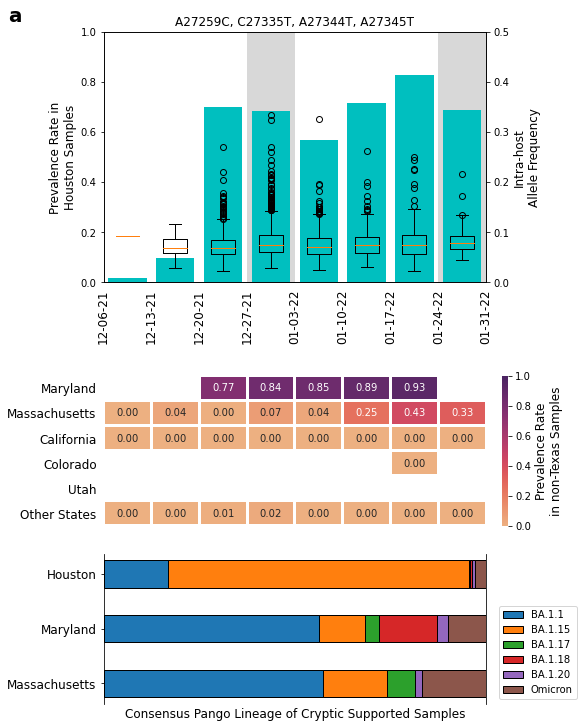

In [55]:
freq_cutoff = 0.02

fontsize = 12
fig, axes  = plt.subplots(3, 1, figsize=(8, 10), sharex=False, constrained_layout=True,
                         gridspec_kw={'height_ratios': [5, 3, 3], 'hspace':0.35})

# Barplot Prevalence Rate in Houston

x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label, houston_df)

ax = axes[0]
x = np.arange(8)
ax.bar(x, ww_counts, color='gray', alpha=0.3, width=1)
bar = ax.bar(x, p_rates, color='c')
#ax.scatter(x, ww_counts, marker="P", s=60, color='black')

ax.set_ylim(0,1)
ax.set_ylabel('Prevalence Rate in\nHouston Samples', fontsize=fontsize)
ax.set_title(", ".join(mut_label.split(';')))

# Boxplot of AF in Houston

ax_twin = ax.twinx()
ax_twin.boxplot(freqs, 
                positions=x,
                showmeans=False)
ax_twin.set_ylim(0, 0.5)
ax_twin.set_ylabel('Intra-host\nAllele Frequency', fontsize=fontsize)

x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)
ax.xaxis.set_ticks_position('none')
ax.set_xlabel(' ', fontsize=fontsize)

ax.text(-0.25, 1.1, f'a', transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')
# Heatmap

heatmap_array, state_labels = get_heatmap_array(mut_label)
state_labels.append('Other States')

sns.heatmap(heatmap_array, linewidth=2, 
            ax=axes[1],
            vmin=0,
            vmax=1,
            cmap='flare',
            yticklabels=state_labels,
            xticklabels=[],
            annot=True, fmt=".2f",
            cbar_kws={'label': 'Prevalence Rate\nin non-Texas Samples'},)

axes[1].figure.axes[-1].yaxis.label.set_size(fontsize)

axes[1].xaxis.set_ticks_position('none')
axes[1].yaxis.set_ticks_position('none')
axes[1].set_yticklabels(state_labels, fontsize=fontsize)
axes[1].set_xlabel(' ', fontsize=fontsize)

# bar
df = pd.concat(get_lineage_plot_data(mut_label), axis=0).fillna(0)
df = df.div(df.sum(axis=1), axis=0)
df = df[['BA.1.1', 'BA.1.15', 'BA.1.17', 'BA.1.18', 'BA.1.20', 'Omicron']]

ax = axes[2]
y = df.index.to_list()
lineages = df.columns.to_list()
for idx, lineage in enumerate(lineages):
    if idx == 0: 
        ax.barh(y, df[lineage].to_list(), align='center', height=.5, label=lineage, edgecolor='black')
        sum_array = df[lineage].to_list()
    else:
        ax.barh(y, df[lineage].to_list(), align='center', height=.5, label=lineage, left=sum_array, edgecolor='black')
        sum_array = list(map(add, sum_array, df[lineage].to_list())) 
ax.set_yticks(y)
ax.set_yticklabels(y, fontsize=fontsize)
ax.set_xlabel('Consensus Pango Lineage of Cryptic Supported Samples', fontsize=fontsize)

ax.set_xticks([])
#ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
#ax.set_title('Run Time by Job')

ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
#ax.spines["left"].set_visible(False)

ax.set_xlim(0,1)
ax.legend(loc=4, bbox_to_anchor=(1.25, 0, 0, 0))

fig.savefig('c1.png', transparent=False, facecolor='white', dpi=300, bbox_inches = "tight")

# Plot 2

In [56]:
mut_label = selected_cryptic_mutations[7]
mut_label

'C10449A;T10459C'

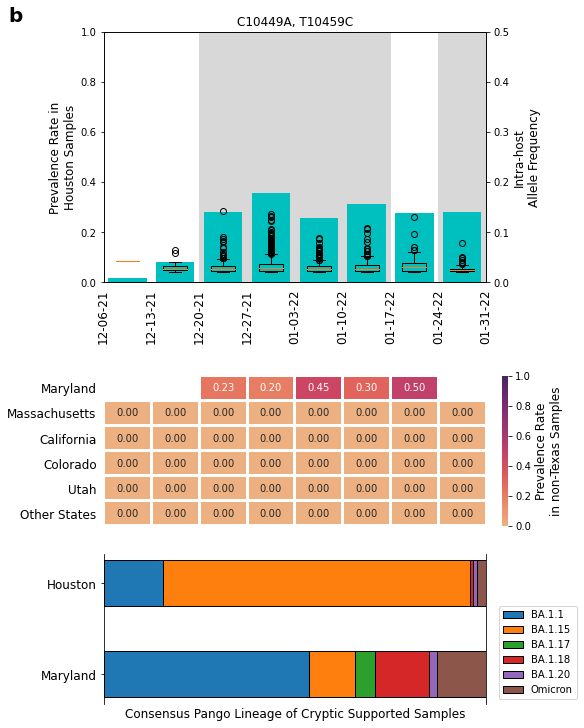

In [57]:
freq_cutoff = 0.02

fontsize = 12
fig, axes  = plt.subplots(3, 1, figsize=(8, 10), sharex=False, constrained_layout=True,
                         gridspec_kw={'height_ratios': [5, 3, 3], 'hspace':0.35})

# Barplot Prevalence Rate in Houston

x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label, houston_df)

ax = axes[0]
x = np.arange(8)
ax.bar(x, ww_counts, color='gray', alpha=0.3, width=1)
bar = ax.bar(x, p_rates, color='c')
#ax.scatter(x, ww_counts, marker="P", s=60, color='black')

ax.set_ylim(0,1)
ax.set_ylabel('Prevalence Rate in\nHouston Samples', fontsize=fontsize)
ax.set_title(", ".join(mut_label.split(';')))

# Boxplot of AF in Houston

ax_twin = ax.twinx()
ax_twin.boxplot(freqs, 
                positions=x,
                showmeans=False)
ax_twin.set_ylim(0, 0.5)
ax_twin.set_ylabel('Intra-host\nAllele Frequency', fontsize=fontsize)

x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)
ax.xaxis.set_ticks_position('none')
ax.set_xlabel(' ', fontsize=fontsize)

ax.text(-0.25, 1.1, f'b', transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top')

# Heatmap

heatmap_array, state_labels = get_heatmap_array(mut_label)
state_labels.append('Other States')

sns.heatmap(heatmap_array, linewidth=2, 
            ax=axes[1],
            vmin=0,
            vmax=1,
            cmap='flare',
            yticklabels=state_labels,
            xticklabels=[],
            annot=True, fmt=".2f",
            cbar_kws={'label': 'Prevalence Rate\nin non-Texas Samples'},)

axes[1].figure.axes[-1].yaxis.label.set_size(fontsize)

axes[1].xaxis.set_ticks_position('none')
axes[1].yaxis.set_ticks_position('none')
axes[1].set_yticklabels(state_labels, fontsize=fontsize)
axes[1].set_xlabel(' ', fontsize=fontsize)

# bar
df = pd.concat(get_lineage_plot_data(mut_label), axis=0).fillna(0)
df = df.div(df.sum(axis=1), axis=0)
df = df[['BA.1.1', 'BA.1.15', 'BA.1.17', 'BA.1.18', 'BA.1.20', 'Omicron']]

ax = axes[2]
y = df.index.to_list()
lineages = df.columns.to_list()
for idx, lineage in enumerate(lineages):
    if idx == 0: 
        ax.barh(y, df[lineage].to_list(), align='center', height=.5, label=lineage, edgecolor='black')
        sum_array = df[lineage].to_list()
    else:
        ax.barh(y, df[lineage].to_list(), align='center', height=.5, label=lineage, left=sum_array, edgecolor='black')
        sum_array = list(map(add, sum_array, df[lineage].to_list())) 
ax.set_yticks(y)
ax.set_yticklabels(y, fontsize=fontsize)
ax.set_xlabel('Consensus Pango Lineage of Cryptic Supported Samples', fontsize=fontsize)

ax.set_xticks([])
#ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
#ax.set_title('Run Time by Job')

ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
#ax.spines["left"].set_visible(False)

ax.set_xlim(0,1)
ax.legend(loc=4, bbox_to_anchor=(1.25, 0, 0, 0))

fig.savefig('c2.png', transparent=False, facecolor='white', dpi=300, bbox_inches = "tight")

# Plot 3

In [36]:
mut_label = selected_cryptic_mutations[-2]
mut_label

'A27344T;A27345T;A27354G'

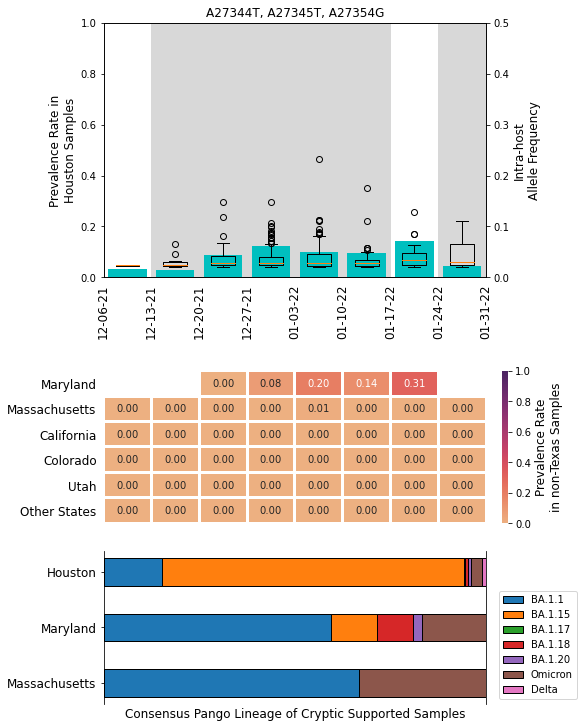

In [37]:
freq_cutoff = 0.02

fontsize = 12
fig, axes  = plt.subplots(3, 1, figsize=(8, 10), sharex=False, constrained_layout=True,
                         gridspec_kw={'height_ratios': [5, 3, 3], 'hspace':0.35})

# Barplot Prevalence Rate in Houston

x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label, houston_df)

ax = axes[0]
x = np.arange(8)
ax.bar(x, ww_counts, color='gray', alpha=0.3, width=1)
bar = ax.bar(x, p_rates, color='c')
#ax.scatter(x, ww_counts, marker="P", s=60, color='black')

ax.set_ylim(0,1)
ax.set_ylabel('Prevalence Rate in\nHouston Samples', fontsize=fontsize)
ax.set_title(", ".join(mut_label.split(';')))

# Boxplot of AF in Houston

ax_twin = ax.twinx()
ax_twin.boxplot(freqs, 
                positions=x,
                showmeans=False)
ax_twin.set_ylim(0, 0.5)
ax_twin.set_ylabel('Intra-host\nAllele Frequency', fontsize=fontsize)

x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)
ax.xaxis.set_ticks_position('none')
ax.set_xlabel(' ', fontsize=fontsize)

# Heatmap

heatmap_array, state_labels = get_heatmap_array(mut_label)
state_labels.append('Other States')

sns.heatmap(heatmap_array, linewidth=2, 
            ax=axes[1],
            vmin=0,
            vmax=1,
            cmap='flare',
            yticklabels=state_labels,
            xticklabels=[],
            annot=True, fmt=".2f",
            cbar_kws={'label': 'Prevalence Rate\nin non-Texas Samples'},)

axes[1].figure.axes[-1].yaxis.label.set_size(fontsize)

axes[1].xaxis.set_ticks_position('none')
axes[1].yaxis.set_ticks_position('none')
axes[1].set_yticklabels(state_labels, fontsize=fontsize)
axes[1].set_xlabel(' ', fontsize=fontsize)

# bar
df = pd.concat(get_lineage_plot_data(mut_label), axis=0).fillna(0)
df = df.div(df.sum(axis=1), axis=0)
df = df[['BA.1.1', 'BA.1.15', 'BA.1.17', 'BA.1.18', 'BA.1.20', 'Omicron', 'Delta']]

ax = axes[2]
y = df.index.to_list()
lineages = df.columns.to_list()
for idx, lineage in enumerate(lineages):
    if idx == 0: 
        ax.barh(y, df[lineage].to_list(), align='center', height=.5, label=lineage, edgecolor='black')
        sum_array = df[lineage].to_list()
    else:
        ax.barh(y, df[lineage].to_list(), align='center', height=.5, label=lineage, left=sum_array, edgecolor='black')
        sum_array = list(map(add, sum_array, df[lineage].to_list())) 
ax.set_yticks(y)
ax.set_yticklabels(y, fontsize=fontsize)
ax.set_xlabel('Consensus Pango Lineage of Cryptic Supported Samples', fontsize=fontsize)

ax.set_xticks([])
#ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
#ax.set_title('Run Time by Job')

ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
#ax.spines["left"].set_visible(False)

ax.set_xlim(0,1)
ax.legend(loc=4, bbox_to_anchor=(1.25, 0, 0, 0))

fig.savefig('c3.png', transparent=False, facecolor='white', dpi=300, bbox_inches = "tight")